### Détails des étapes :
1. **Critères et création des points d'objet** :
   - Les critères définissent quand l'algorithme de détection des coins s'arrête.
   - `objp` représente les points d'un échiquier dans le monde réel, avec z=0.

2. **Détection des coins dans les images** :
   - Conversion des images en niveaux de gris pour faciliter la détection des coins.
   - Détection des coins pour chaque image et stockage des points 2D/3D.

3. **Calibration de la caméra** :
   - Calcul des matrices intrinsèques (`mtx`) et des vecteurs de rotation/translation (`rvecs`, `tvecs`).

4. **Calcul des matrices de rotation et translation** :
   - Les vecteurs de rotation sont convertis en matrices.
   - Les matrices de rotation sont étendues avec les vecteurs de translation pour former des matrices 3x4.

5. **Projection et position des caméras** :
   - Les matrices de projection (3x4) combinent les paramètres intrinsèques et extrinsèques.
   - Les centres des caméras sont calculés dans le référentiel monde via des coordonnées homogènes.

Ce format garde le code clair et précise chaque étape clé sans surcharger d'informations inutiles.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob

# Critères d'arrêt pour l'algorithme de détection des coins de l'échiquier
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Création des points d'objet 3D pour un échiquier de 7x7 intersections
objp = np.zeros((7*7, 3), np.float32)  # Initialisation d'un tableau de points (z=0 par défaut)
objp[:, :2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2)  # Coordonnées x, y de la grille d'intersections

# print(objp)

# Listes pour stocker les points 3D (réels) et les points 2D (dans l'image)
objpoints = []  # Points 3D
imgpoints = []  # Points 2D

# Parcours des images d'échiquier correspondantes
for fname in glob.glob('chessboards/c4*.png'):
    img = cv.imread(fname)  # Chargement de l'image
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Conversion de l'image en niveaux de gris
    ret, corners = cv.findChessboardCorners(gray, (7, 7), None)  # Détection des coins de l'échiquier
    if ret:
        objpoints.append(objp)  # Ajout des points 3D correspondants
        imgpoints.append(corners)  # Ajout des coins détectés (points 2D)

# Calibration de la caméra avec les points correspondants 2D et 3D
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# ret : Booléen indiquant si la calibration a réussi
# mtx : Matrice intrinsèque de la caméra
# dist : Coefficients de distorsion (non utilisés ici)
# rvecs, tvecs : Vecteurs de rotation et translation pour chaque image

# Conversion des vecteurs de rotation en matrices de rotation
rmatRight = cv.Rodrigues(rvecs[0])[0]  # Matrice de rotation pour la caméra droite
rmatLeft = cv.Rodrigues(rvecs[1])[0]   # Matrice de rotation pour la caméra gauche

# Ajout des vecteurs de translation pour obtenir des matrices 3x4
rotMatRight = np.concatenate((rmatRight, tvecs[0]), axis=1)
rotMatLeft = np.concatenate((rmatLeft, tvecs[1]), axis=1)

# Matrices de projection des caméras (intrinsèque * rotation-translation)
camLeft = mtx @ rotMatLeft
camRight = mtx @ rotMatRight

# Calcul des centres des caméras dans le référentiel monde (coordonnées homogènes 4x1)
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft, [[0, 0, 0, 1]]), axis=0)) @ np.transpose([[0, 0, 0, 1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight, [[0, 0, 0, 1]]), axis=0)) @ np.transpose([[0, 0, 0, 1]])


### Détails :
1. **Introduction de la fonction** : Explique son rôle global (visualisation de la position des caméras et des points 3D).
2. **Étapes principales** :
   - Création de la figure 3D et des axes.
   - Affichage des points de l'objet 3D.
   - Affichage des positions des caméras gauche et droite avec des couleurs distinctes.
3. **Appel de la fonction** : Indique que la scène est générée lorsqu'on appelle `plotDotWorld`.

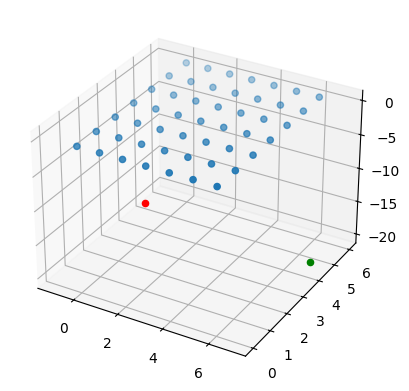

In [5]:
# Fonction pour visualiser dans l'espace 3D la position des caméras et de l'objet (jeu d'échecs)
def plotDotWorld():
    # Création d'une figure 3D
    fig = plt.figure()                                       # Crée une figure vide
    ax = plt.axes(projection='3d')                          # Ajoute des axes 3D pour une visualisation en trois dimensions
    
    # Affichage des points 3D de l'objet
    ax.scatter3D(objp[:, 0], objp[:, 1], objp[:, 2])         # Place les points de l'objet (objp) dans l'espace 3D
    
    # Affichage de la position de la caméra gauche
    x, y, z, d = camWorldCenterLeft                          # Coordonnées homogènes de la caméra gauche
    ax.scatter(x, y, z, c='g', marker='o')                   # Représente la caméra gauche par un point vert ('g')
    
    # Affichage de la position de la caméra droite
    x2, y2, z2, d2 = camWorldCenterRight                     # Coordonnées homogènes de la caméra droite
    ax.scatter(x2, y2, z2, c='r', marker='o')                # Représente la caméra droite par un point rouge ('r')
    
    # Affichage de la figure 3D
    plt.show()                                               # Affiche la figure

# Appel de la fonction pour afficher la scène 3D
plotDotWorld()


mask


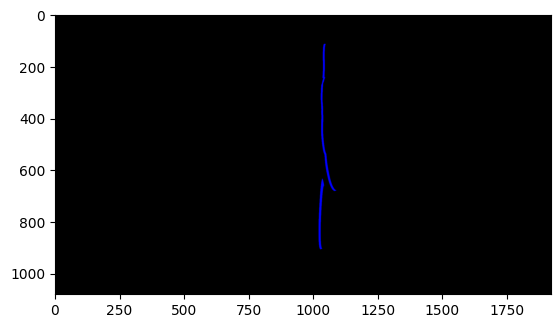

In [6]:
# Affiche le résultat de la fonction getImgLine(fname) pour une image donnée

# Chargement de l'image
img = cv.imread("scanRight/scan0011.png")  # Charge l'image spécifiée dans une variable

# Application d'un seuillage pour isoler les éléments souhaités
ret, mask = cv.threshold(img, 127, 255, cv.THRESH_TOZERO)  
# Seuil fixé à 127 : les pixels ayant une intensité inférieure à ce seuil sont mis à zéro
# Méthode THRESH_TOZERO : conserve les pixels supérieurs au seuil sans modification

# Affichage du masque obtenu
print("mask")         # Indique dans la console que l'image affichée est le masque
plt.imshow(mask)      # Affiche l'image transformée sous forme de masque


### Détails :
1. **Structure générale** : 
   - Explique les fonctions de manière claire et leur rôle dans le contexte (e.g., calcul de matrice fondamentale, extraction de lignes rouges, etc.).

2. **Détails spécifiques** :
   - `crossMat(v)` : Calcul de la matrice croisée pour un vecteur.
   - `matFondamental` : Décrit étape par étape le calcul de la matrice fondamentale.
   - `getImgLine` : Simplifie une image en isolant la ligne rouge.

3. **Boucle principale dans `findEpilines`** :
   - Décompose la logique : formatage des fichiers, extraction de la ligne, calcul des points homogènes, et utilisation de la matrice fondamentale.

4. **Finalité** :
   - Clarifie le rôle des variables globales comme `Fondamental` et le format final des données (liste des épilignes et points).

Avec ces commentaires, le code est plus facile à suivre tout en restant concis et directement lié à son objectif.

In [7]:
# Fonction pour calculer la matrice de produit vectoriel (matrice croisée) d'un vecteur
def crossMat(v):
    # Extrait les composantes du vecteur (assume v sous forme [[x], [y], [z]])
    v = v[:, 0]  
    # Retourne la matrice croisée de v
    return np.array([[0, -v[2], v[1]], 
                     [v[2], 0, -v[0]], 
                     [-v[1], v[0], 0]])

# Fonction pour calculer la matrice fondamentale entre deux caméras
def matFondamental(camLeft, centerRight, camRight):
    # Pseudo-inverse de la matrice de la caméra droite, multipliée par la gauche
    # Multiplie ensuite par le produit matriciel des coordonnées homogènes (camLeft @ centerRight)
    # Utilise le produit vectoriel via crossMat pour finaliser le calcul
    return np.array(crossMat(camLeft @ centerRight) @ camLeft @ np.linalg.pinv(camRight))

# Fonction pour isoler la ligne rouge d'une image donnée
def getImgLine(fname):              
    img = cv.imread(fname)                                      # Charge l'image spécifiée
    red = img[:, :, 2]                                          # Extrait le canal rouge (évite erreurs dans epilines)
    ret, mask = cv.threshold(red, 127, 255, cv.THRESH_TOZERO)   # Conserve uniquement les pixels rouges au-dessus du seuil
    return mask                                                 # Retourne une image masque

# Fonction pour trouver les épilignes à partir des images
def findEpilines(path):
    epilines = []                                               # Liste pour stocker les épilignes
    for l in range(26):                                         # Parcourt les 26 images
        # Formate le nom de fichier avec le bon nombre de zéros
        strp = path + ('000' if l < 10 else '00') + str(l) + '.png'
        
        # Obtenez l'image masque avec uniquement la ligne
        ImgLine = getImgLine(strp)
        pointsLeft = [[], [], []]                               # Points homogènes pour l'image gauche

        for index, line in enumerate(ImgLine):                 # Parcourt chaque ligne de pixels de l'image
            for pixel in line:                                  # Parcourt chaque pixel de la ligne
                if pixel != 0:                                  # Si le pixel est non nul (fait partie de la ligne rouge)
                    pixel = 1                                   # Normalise la valeur du pixel à 1
            
            try:
                # Calcul des coordonnées moyennes pondérées par la valeur des pixels
                pointsLeft[0].append(np.average(range(1920), weights=line))  # Moyenne pondérée pour x
                pointsLeft[1].append(index)                                  # Coordonnée y (index de la ligne)
                pointsLeft[2].append(1)                                      # Coordonnées homogènes
            except:
                pass  # Ignorer les exceptions si aucune ligne valide n'est trouvée
            
        # Calcul des épilignes pour l'image droite avec la matrice fondamentale
        epilinesRight = Fondamental @ pointsLeft  
        epilines.append([pointsLeft, epilinesRight])  # Ajoute les points et leurs épilignes correspondants
    return epilines

# Calcul de la matrice fondamentale entre les deux caméras
Fondamental = matFondamental(camRight, camWorldCenterLeft, camLeft)

# Calcul des épilignes pour les images du dossier 'scanLeft/'
epl = findEpilines('scanLeft/')  # Format final : [[pointsLeft], [epilinesRight]]
# print(epl)  # Affiche les épilignes pour chaque image
# epl_right = findEpilines('scanRight/')  # Format final : [[pointsLeft], [epilinesRight]]


In [7]:
# def drawAvgPoint(fname,EplLeft):                                                    # Cette fonction affiche les points de la ligne laser, input le nom de l'img et les pointsLeft de l'img
#     img = cv.imread(fname)                                                          # 
#     i = 0
#     while i< len(EplLeft[0]):                                                       # Tant qu'il y a des "avg" qui n'ont pas été couverts
#         color = tuple(np.random.randint(0,255,3).tolist())                          #
#         img = cv.circle(img,(int(EplLeft[0][i]),int(EplLeft[1][i])),5,color,-1)     #
#         i += 10                                                                     #
#     plt.imshow(img)                                                                 # On affiche l'image modifiée
#     plt.show()      


# def lineY(coef,x):
#     a,b,c = coef
#     return-(c+a*x)/b


# def drawEpl(fname,EplRight):
#     img = cv.imread(fname)
#     coef , length = EplRight.shape
#     for i in range(0,length,40):
#         #print(EplRight[:,i])
#         plt.plot([0,1919],[lineY(EplRight[:,i],0),lineY(EplRight[:,i],1919)],'r')
        
#     plt.imshow(img)
#     plt.show()
    
# drawAvgPoint('scanLeft/0010.png',epl[10][0])
# drawEpl('scanRight/scan0010.png',epl[10][1])

# drawAvgPoint('scanLeft/0011.png',epl[11][0])
# drawEpl('scanRight/scan0011.png',epl[11][1])

# drawAvgPoint('scanLeft/0012.png',epl[12][0])
# drawEpl('scanRight/scan0012.png',epl[12][1])


GIF créé : output.gif


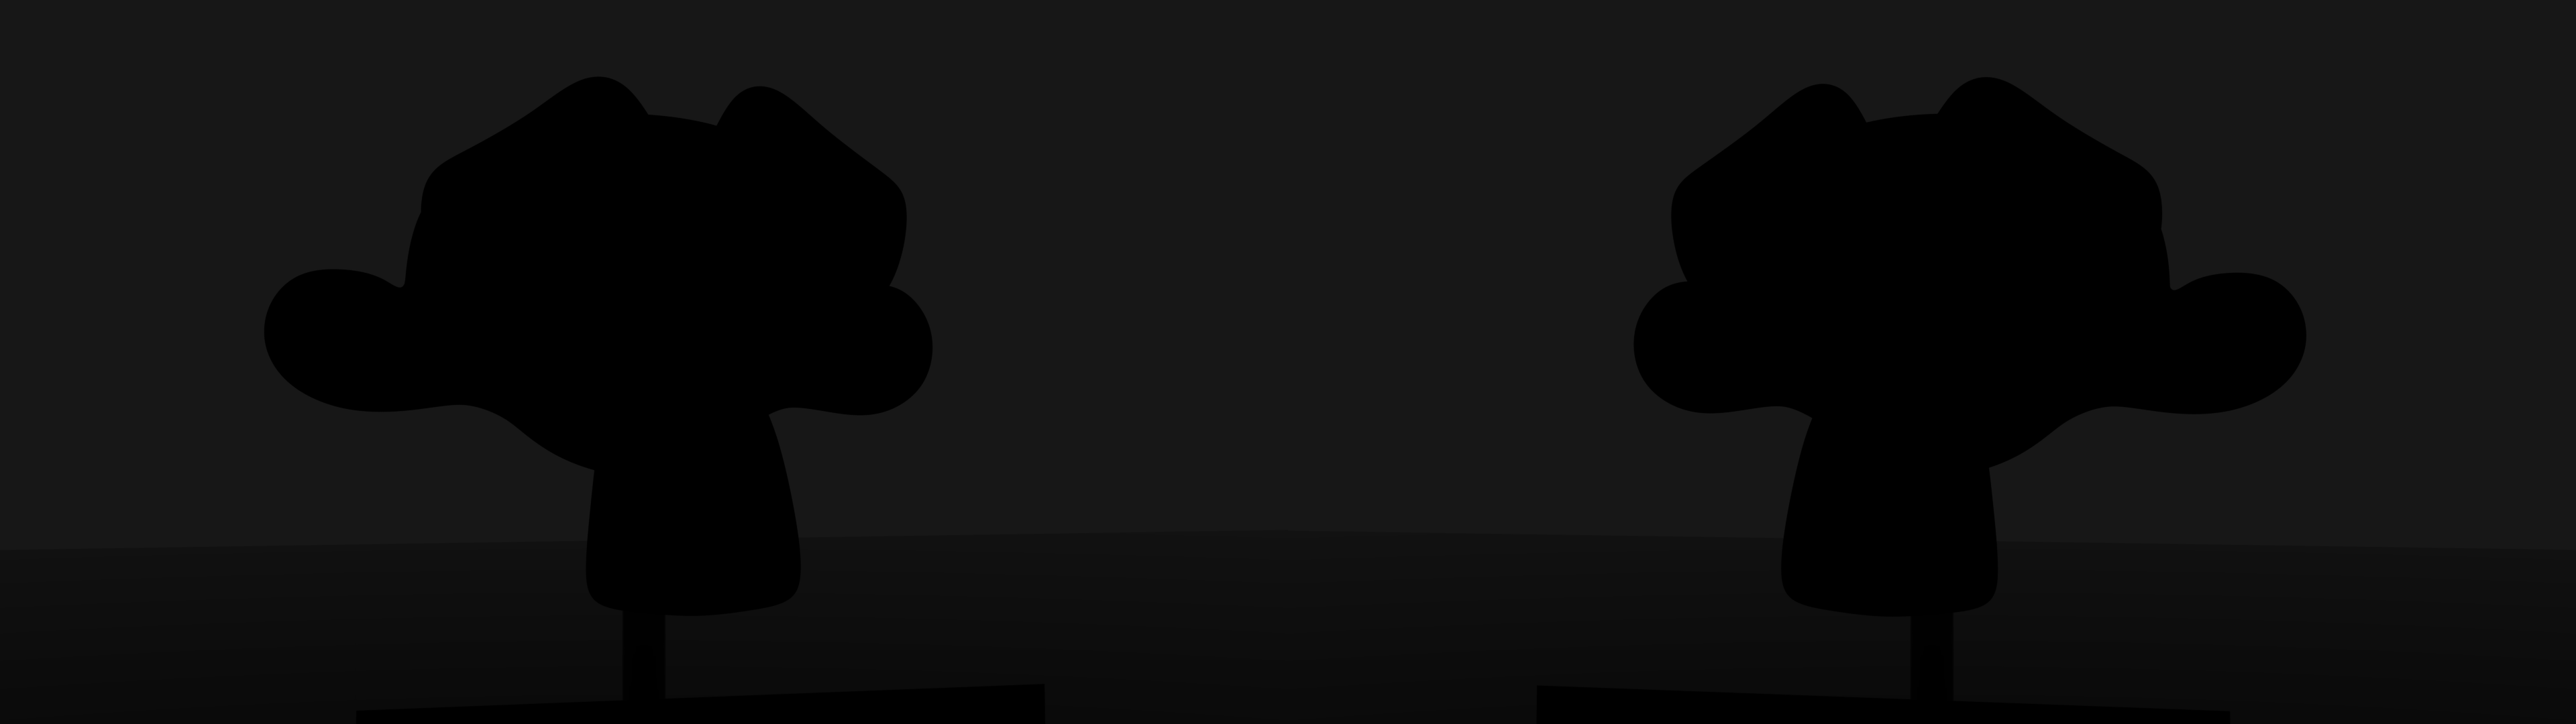

In [8]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from IPython.display import Image as pythImage, display

def lineY(coef, x):
    """
    Calcule la coordonnée Y sur une ligne donnée les coefficients.
    """
    a, b, c = coef
    return -(c + a * x) / b


def drawAvgPoint(img, EplLeft):
    """
    Ajoute des points colorés sur une image à partir des coordonnées fournies.
    """
    i = 0
    while i < len(EplLeft[0]):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        img = cv.circle(img, (int(EplLeft[0][i]), int(EplLeft[1][i])), 5, color, -1)
        i += 10
    return img


# def drawEpl(img, EplRight):
#     """
#     Ajoute des lignes épipolaires à l'image en fonction des coefficients fournis.
#     """
#     coef, length = EplRight.shape
#     for i in range(0, length, 40):
#         plt.plot([0, 1919], [lineY(EplRight[:, i], 0), lineY(EplRight[:, i], 1919)], 'r')
#     return img

def drawEpl(img, EplRight):
    """
    Ajoute des lignes épipolaires directement sur l'image en fonction des coefficients fournis.
    :param img: Image sur laquelle dessiner les lignes.
    :param EplRight: Matrice contenant les coefficients des lignes épipolaires.
    """
    coef, length = EplRight.shape
    for i in range(0, length, 10):  # Espacement des lignes
        # Calculer les points de la ligne
        y1 = int(lineY(EplRight[:, i], 0))       # Point à x=0
        y2 = int(lineY(EplRight[:, i], img.shape[1] - 1))  # Point à x=largeur de l'image

        # Dessiner la ligne sur l'image
        color = (0, 0, 255)  # Couleur rouge (BGR)
        thickness = 2  # Épaisseur de la ligne
        cv.line(img, (0, y1), (img.shape[1] - 1, y2), color, thickness)

    return img



def process_folder(left_folder, right_folder, EplLeft, EplRight, output_gif_path, duration=300):
    """
    Parcourt un dossier d'images, applique drawAvgPoint et drawEpl sur chaque image, 
    et génère un GIF.
    :param left_folder: Dossier contenant les images pour drawAvgPoint.
    :param right_folder: Dossier contenant les images pour drawEpl.
    :param EplLeft: Liste des points pour drawAvgPoint.
    :param EplRight: Liste des coefficients pour drawEpl.
    :param output_gif_path: Chemin du fichier GIF de sortie.
    :param duration: Durée de chaque frame en millisecondes.
    """
    left_images = sorted([f for f in os.listdir(left_folder) if f.endswith('.png')])
    right_images = sorted([f for f in os.listdir(right_folder) if f.endswith('.png')])

    frames = []  # Liste pour stocker les frames

    for idx in range(len(left_images)):
        # Charger les images
        left_path = os.path.join(left_folder, left_images[idx])
        right_path = os.path.join(right_folder, right_images[idx])

        img_left = cv.imread(left_path)
        img_right = cv.imread(right_path)

        # Appliquer les transformations
        img_left = drawAvgPoint(img_left, EplLeft[idx][0])
        img_right = drawEpl(img_right, EplRight[idx][1])

        # Combiner les deux images côte à côte
        combined_width = img_left.shape[1] + img_right.shape[1]
        combined_height = max(img_left.shape[0], img_right.shape[0])
        combined_img = np.zeros((combined_height, combined_width, 3), dtype=np.uint8)

        combined_img[:img_left.shape[0], :img_left.shape[1]] = img_left
        combined_img[:img_right.shape[0], img_left.shape[1]:] = img_right

        # Convertir en format compatible Pillow (RGB)
        combined_img_rgb = cv.cvtColor(combined_img, cv.COLOR_BGR2RGB)
        frames.append(Image.fromarray(combined_img_rgb))

    # Créer le GIF
    if frames:
        frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=duration, loop=0)
        print(f"GIF créé : {output_gif_path}")
    else:
        print("Aucune image traitée.")


# Exemple d'utilisation :
# Supposons que EplLeft et EplRight soient définis
# EplLeft = [...]  # Liste des points
# EplRight = [...]  # Liste des coefficients

process_folder(
    left_folder='scanLeft',
    right_folder='scanRight',
    EplLeft=epl,  # Assurez-vous que cette variable contient les points
    EplRight=epl,  # Assurez-vous que cette variable contient les coefficients
    output_gif_path='output.gif',
    duration=300
)

display(pythImage(filename='output.gif'))


In [9]:
def getReddAvg(fname):
    red = getImgLine(fname)
    redPoints = [[],[],[]]

    for i, line in enumerate(red):
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            redPoints[0].append(np.average(range(1920), weights = line))
            redPoints[1].append(i)
            redPoints[2].append(1)
        except:
            pass
    return redPoints


def eplRedPoints(path,EplRight):
    points = []
    for l in range(26):
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        redPoints = getReddAvg(strp)
        scan = cv.imread(strp)

        pointsRight = [[],[],[]]
        eplImg = EplRight[l][1]
        # print(strp)
        for i in range(len(eplImg[0])):
            try : 
                x = int(redPoints[0][i])
                y = int(lineY(eplImg[:,i],x))
                pointsRight[0].append(x)
                pointsRight[1].append(y)
                pointsRight[2].append(1)
                
                color = tuple(np.random.randint(0,255,3).tolist())
                scan = cv.circle(scan,(x,y),5,color,-1)
            except:
                pass
        points.append(pointsRight)
        # plt.imshow(scan)
        # plt.show()
    return points


pointsRight = eplRedPoints('scanRight/scan',epl)
print(pointsRight)
pointsLeft = eplRedPoints('scanLeft/',epl)
print(pointsLeft)

[[[], [], []], [[], [], []], [[], [], []], [[1497, 1498, 1498, 1499, 1499, 1499, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1501, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1502, 1503, 1503, 1503, 1503, 1503, 1503, 1503], [479, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 542, 543, 544, 545, 546, 547, 548

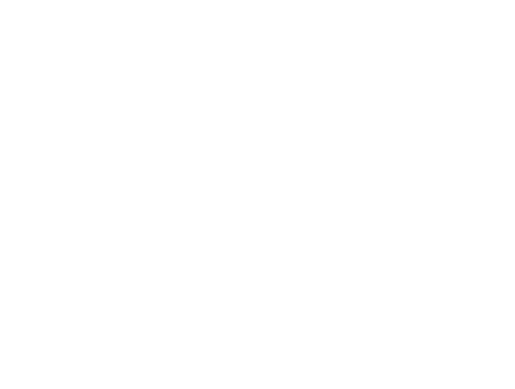

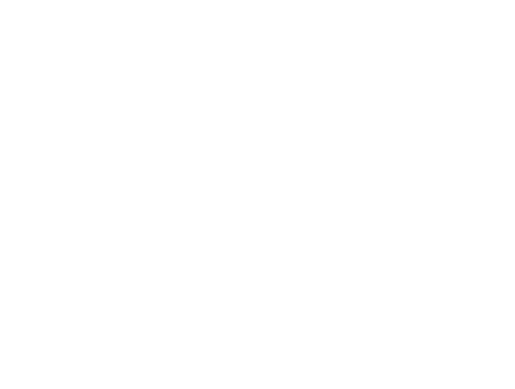

In [ ]:
import numpy as np
import json


def arrayToVector(p):
    return np.array([p[0], p[1], p[2]])

def intersect_line_line(p1, p2, p3, p4):
    """
    Trouve le point d'intersection entre deux lignes dans l'espace 3D.
    p1, p2 : Points de la première ligne
    p3, p4 : Points de la deuxième ligne
    """
    # Calcul des vecteurs directeurs
    u = p2 - p1
    v = p4 - p3
    w = p1 - p3
    
    # Calcul des projections scalaires
    a = np.dot(u, u)
    b = np.dot(u, v)
    c = np.dot(v, v)
    d = np.dot(u, w)
    e = np.dot(v, w)
    
    denominator = a * c - b * b
    if np.isclose(denominator, 0):
        return None  # Les lignes sont parallèles ou quasi-parallèles
    
    # Paramètres des points d'approche sur chaque ligne
    sc = (b * e - c * d) / denominator
    tc = (a * e - b * d) / denominator
    
    # Points d'approche sur chaque ligne
    point_on_line1 = p1 + sc * u
    point_on_line2 = p3 + tc * v
    
    # Retourne les points d'approche (peuvent être utilisés pour calculer un point moyen si nécessaire)
    return (point_on_line1, point_on_line2)


def getIntersection(pointsLeft, pointsRight):
    pL = np.array(pointsLeft)
    pR = np.array(pointsRight)
    
    camCenterRight = np.transpose(camWorldCenterRight)[0]
    camCenterLeft = np.transpose(camWorldCenterLeft)[0]
    
    # Calcul des points de l'objet en appliquant la pseudo-inverse
    leftObject = np.linalg.pinv(camLeft) @ pL
    rightObject = np.linalg.pinv(camRight) @ pR
    
    # Conversion en vecteurs NumPy
    leftEndVec = arrayToVector(leftObject)
    rightEndVec = arrayToVector(rightObject)
    leftStartVec = arrayToVector(camCenterLeft)
    rightStartVec = arrayToVector(camCenterRight)
    
    # Utilisation de la fonction intersect_line_line
    return intersect_line_line(leftStartVec, leftEndVec, rightStartVec, rightEndVec)



def draw3DLine(start,end):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    x_start,y_start,z_start = start
    x_end,y_end,z_end = end

    print("start = ({},{},{})".format(x_start,y_start,z_start))
    print("end = ({},{},{})\n".format(x_end,y_end,z_end))

    ax.scatter(x_start,y_start,z_start,c='r',marker='o')
    ax.plot([x_start ,x_end],[y_start,y_end],[z_start,z_end])


def getObjectPoint():
    point = [[],[],[]]
    for l in range(26):
        pointsLeft = np.array(epl[l][0])
        
        pointRight = np.array(pointsRight[l])
        for i in range(len(pointsLeft[0])):
            try:
                
                # calcul du point d'intersection sur l'objet -> on obtient une liste de vector
                intersection = getIntersection(pointsLeft[:,i],pointRight[:,i])
                # print(intersection)
                for inter in intersection:
                    inter *= 1000
                    x,y,z = inter
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z)
            except:
                pass
    return np.array(point)
        

def drawPointObject(point):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.scatter3D(point[0,:],point[1,:],point[2,:],s = 100, c='black',marker='x')     
        
    ax.view_init(-90,-70)
    plt.axis('off')
    plt.show()
    

def drawSurfaceObject(point):
    figure = plt.figure()
    ax = Axes3D(figure)
    ax.plot_trisurf(point[0,:],point[1,:],point[2,:])     

    ax.view_init(-95,-50)
    plt.axis('off')
    plt.show()
    
    
def pointToJson(point):
    data = {'x':point[0,:].tolist(),'y':point[1,:].tolist(),'z':point[2,:].tolist()}
    with open('point.txt','+w') as file:
        json.dump(data,file)


point = getObjectPoint()
drawSurfaceObject(point)
drawPointObject(point)
pointToJson(point)


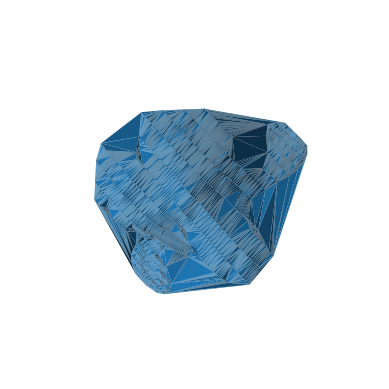

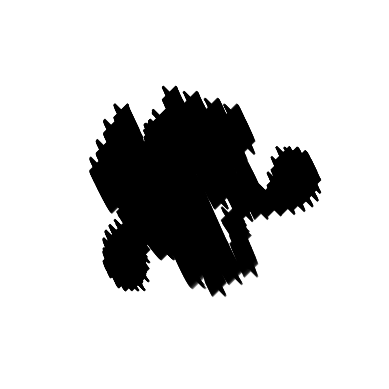

In [12]:
from mathutils import geometry as pygeo
from mathutils import Vector
import json


def arrayToVector(p):
    return Vector((p[0],p[1],p[2]))


def getIntersection(pointsLeft,pointsRight):
    
    pL = np.array(pointsLeft)
    pR = np.array(pointsRight)
    
    camCenterRight = np.transpose(camWorldCenterRight)[0]
    camCenterLeft = np.transpose(camWorldCenterLeft)[0]
    
    # calcul du point sur l'object en applicant la pseudo-inverse de la camera sur le point trouvé plus-haut
    
    leftObject = (np.linalg.pinv(camLeft) @ pL)
    rightObject = (np.linalg.pinv(camRight) @ pR) 
    
    # conversion des np.array en mathutils.Vector pour l'utilisation de la methode d'intersection
    
    leftEndVec = arrayToVector(leftObject)
    rightEndVec = arrayToVector(rightObject)
    
    leftStartVec = arrayToVector(camCenterLeft)
    rightStartVec = arrayToVector(camCenterRight)
    
    # affichage des lignes reliant centre à point objet
    
    '''
    draw3DLine(camCenterLeft,leftObject)
    draw3DLine(camCenterRight,rightObject)
    plt.show()
    '''
    
    # utilisation de mathutils.geometry.intersect_line_line pour trouver l'intersection des lingnes passant par les 2 
    # points. 
    return pygeo.intersect_line_line(leftStartVec,leftEndVec,rightStartVec,rightEndVec)


def draw3DLine(start,end):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    x_start,y_start,z_start = start
    x_end,y_end,z_end = end

    print("start = ({},{},{})".format(x_start,y_start,z_start))
    print("end = ({},{},{})\n".format(x_end,y_end,z_end))

    ax.scatter(x_start,y_start,z_start,c='r',marker='o')
    ax.plot([x_start ,x_end],[y_start,y_end],[z_start,z_end])


def getObjectPoint():
    point = [[],[],[]]
    for l in range(26):
        pointsLeft = np.array(epl[l][0])
        
        pointRight = np.array(pointsRight[l])
        for i in range(len(pointsLeft[0])):
            try:
                
                # calcul du point d'intersection sur l'objet -> on obtient une liste de vector
                intersection = getIntersection(pointsLeft[:,i],pointRight[:,i])
                # print(intersection)
                for inter in intersection:
                    inter *= 1000
                    x,y,z = inter
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z)
            except:
                pass
    return np.array(point)
        

# def drawPointObject(point):
#     figure = plt.figure()
#     ax = Axes3D(figure)
    
#     ax.scatter3D(point[0,:],point[1,:],point[2,:],s = 100, c='black',marker='x')     
        
#     ax.view_init(-90,-70)
#     plt.axis('off')
#     plt.show()


def drawPointObject(point):
    """
    Dessine un nuage de points 3D à partir des coordonnées données.
    """
    figure = plt.figure()
    ax = figure.add_subplot(111, projection='3d')  # Crée un axe 3D

    # Dessine les points en 3D
    ax.scatter3D(point[0, :], point[1, :], point[2, :], s=100, c='black', marker='x')

    # Ajuste l'angle de vue
    ax.view_init(-90, -70)
    plt.axis('off')  # Supprime les axes
    plt.show()

    

# def drawSurfaceObject(point):
#     figure = plt.figure()
#     ax = Axes3D(figure)
#     ax.plot_trisurf(point[0,:],point[1,:],point[2,:])     

#     ax.view_init(-95,-50)
#     plt.axis('off')
#     plt.show()

def drawSurfaceObject(point):
    """
    Dessine un objet 3D à partir des points donnés.
    """
    figure = plt.figure()
    ax = figure.add_subplot(111, projection='3d')  # Ajout d'un axe 3D
    ax.plot_trisurf(point[0, :], point[1, :], point[2, :])  # Surface 3D

    ax.view_init(-95, -50)  # Ajuste l'angle de vue
    plt.axis('off')  # Supprime les axes
    plt.show()
    
    
def pointToJson(point):
    data = {'x':point[0,:].tolist(),'y':point[1,:].tolist(),'z':point[2,:].tolist()}
    with open('point.txt','+w') as file:
        json.dump(data,file)


point = getObjectPoint()
drawSurfaceObject(point)
drawPointObject(point)
pointToJson(point)
